# Predictions for Ripple

In [1]:
import yfinance as yf
import ta
from sklearn.ensemble import RandomForestRegressor
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr
from darts.models import NaiveDrift, NaiveSeasonal, TCNModel, BlockRNNModel, TransformerModel, TFTModel
import matplotlib.pyplot as plt
import numpy as np
import torch
import plotly.graph_objects as go
from darts.metrics import mae, rmse, mse, mape
from pytorch_lightning.callbacks import EarlyStopping

torch.manual_seed(1)
np.random.seed(1)



c:\Users\mirja\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsforecast\utils.py:236: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


In [2]:
#actual: actual series
#prediction: predicted series
#print_single can be [True, False]. If True print one prediction associated to 1 model
#otherwise a list of predictions associated to different models
def print_graph(actual, prediction, print_single, model):
    fig = go.Figure()


    fig.add_trace(go.Scatter(x=actual.time_index,
                             y=actual.values().flatten(),
                             name='Real test points'))

    if print_single:
        fig.add_trace(go.Scatter(x=prediction.time_index,
                                 y=prediction.values().flatten(),
                                 name=f'Predicted points ({model})',
                                ))
    else:
        for key, pre in prediction.items():
            fig.add_trace(go.Scatter(x=pre.time_index,
                                     y=pre.values().flatten(),
                                     name=f'Predicted points ({key})',
                                    ))

    fig.update_layout(title_text = "Ripple prices")
    fig.update_xaxes(title_text="Date")
    fig.update_yaxes(title_text="Price")
    fig.show()

In [3]:
#actual: actual series
#prediction: predicted series
#print_single can be [True, False]. If True print one prediction associated to 1 model
#otherwise a list of predictions associated to different models
def print_graph_backtesting(actual, prediction, print_single, model, horizon):
    fig = go.Figure()


    fig.add_trace(go.Scatter(x=actual.time_index,
                             y=actual.values().flatten(),
                             name='Real test points'))

    if print_single:
        fig.add_trace(go.Scatter(x=prediction.time_index,
                                 y=prediction.values().flatten(),
                                 name=f'Predicted points ({model})',
                                ))
    else:
        for key, pre in prediction.items():
            fig.add_trace(go.Scatter(x=pre.time_index,
                                     y=pre.values().flatten(),
                                     name=f'Predicted points ({key})',
                                    ))

    fig.update_layout(title_text = f"Backtesting for Ripple prices with Forecasting Horizon = {horizon}")
    fig.update_xaxes(title_text="Date")
    fig.update_yaxes(title_text="Price")
    fig.show()

In [4]:
#retrieve ripple data
start_date = '2014-09-17'
end_date = '2024-01-23'

df = yf.download('XRP-USD', interval = '1d', start = start_date, end = end_date)
df = df.drop('Adj Close', axis=1)
df = ta.utils.dropna(df)
df = ta.add_all_ta_features(
    df, "Open", "High", "Low", "Close", "Volume", fillna=True
)
df = df.fillna(0)

c:\Users\mirja\AppData\Local\Programs\Python\Python311\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
c:\Users\mirja\AppData\Local\Programs\Python\Python311\Lib\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


In [5]:
df

Open      High       Low     Close      Volume    volume_adi  \
Date                                                                           
2017-11-09  0.217911  0.221791  0.214866  0.217488   147916992 -3.590559e+07   
2017-11-10  0.218256  0.219068  0.205260  0.206483   141032992 -1.519552e+08   
2017-11-11  0.205948  0.214456  0.205459  0.210430   134503008 -1.378279e+08   
2017-11-12  0.210214  0.210214  0.195389  0.197339   251175008 -3.229267e+08   
2017-11-13  0.197472  0.204081  0.197456  0.203442   132567000 -2.159323e+08   
...              ...       ...       ...       ...         ...           ...   
2024-01-18  0.567981  0.568357  0.546129  0.551907  1057710374  3.406572e+11   
2024-01-19  0.551870  0.552995  0.523937  0.544256  1330077736  3.411873e+11   
2024-01-20  0.544244  0.554386  0.539338  0.553126   725888847  3.417916e+11   
2024-01-21  0.553145  0.554770  0.546111  0.546111   494271879  3.412973e+11   
2024-01-22  0.546216  0.548638  0.521917  0.526716  1151736625  3.405593e+11   

              volume_obv  volume_cmf     volume_fi  volume_em  ...  \
Date                                                           ...   
2017-11-09     147916992   -0.242741  0.000000e+00   0.000000  ...   
2017-11-10       6884000   -0.525888 -1.552068e+06  -0.000060  ...   
2017-11-11     141387008   -0.325486 -1.254504e+06  -0.000015  ...   
2017-11-12    -109788000   -0.478674 -1.545022e+06  -0.000042  ...   
2017-11-13      22779000   -0.267509 -1.208725e+06  -0.000010  ...   
...                  ...         ...           ...        ...  ...   
2024-01-18  215924558153   -0.017113 -4.734661e+06  -0.000026  ...   
2024-01-19  214594480417    0.008963 -5.512062e+06  -0.000041  ...   
2024-01-20  215320369264    0.045051 -3.804819e+06   0.000017  ...   
2024-01-21  214826097385    0.003424 -3.756604e+06   0.000006  ...   
2024-01-22  213674360760    0.011348 -6.411078e+06  -0.000035  ...   

            momentum_ppo  momentum_ppo_signal  momentum_ppo_hist  \
Date                                                               
2017-11-09      0.000000             0.000000           0.000000   
2017-11-10     -0.405169            -0.081034          -0.324135   
2017-11-11     -0.573901            -0.179607          -0.394294   
2017-11-12     -1.189571            -0.381600          -0.807971   
2017-11-13     -1.434435            -0.592167          -0.842268   
...                  ...                  ...                ...   
2024-01-18     -2.228636            -1.957164          -0.271472   
2024-01-19     -2.504057            -2.066543          -0.437514   
2024-01-20     -2.571164            -2.167467          -0.403697   
2024-01-21     -2.695000            -2.272974          -0.422026   
2024-01-22     -3.039179            -2.426215          -0.612965   

            momentum_pvo  momentum_pvo_signal  momentum_pvo_hist  \
Date                                                               
2017-11-09      0.000000             0.000000           0.000000   
2017-11-10     -0.372540            -0.074508          -0.298032   
2017-11-11     -1.020169            -0.263640          -0.756529   
2017-11-12      4.597566             0.708601           3.888965   
2017-11-13      2.799838             1.126848           1.672989   
...                  ...                  ...                ...   
2024-01-18     -8.300473            -2.615611          -5.684862   
2024-01-19     -6.924058            -3.477300          -3.446758   
2024-01-20     -9.759422            -4.733725          -5.025697   
2024-01-21    -13.758897            -6.538759          -7.220138   
2024-01-22    -12.100754            -7.651158          -4.449596   

            momentum_kama  others_dr  others_dlr   others_cr  
Date                                                          
2017-11-09       0.217488   0.000000    0.000000    0.000000  
2017-11-10       0.211135  -5.060049   -5.192559   -5.060049  
2017-11-11       0.210746   1.911532    1.

# Feature engineering

In [6]:

split_index = int(len(df) * 0.8)  # 80% for training, 20% for testing
X_train = df.iloc[:split_index].drop('Close', axis=1)
y_train = df.iloc[:split_index]['Close']
X_test = df.iloc[split_index:].drop('Close', axis=1)
y_test = df.iloc[split_index:]['Close']

In [7]:
clf = RandomForestRegressor(n_jobs=-1)
clf.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1)

In [8]:
clf.score(X_test, y_test)

0.9999166039693952

In [9]:
features = {k: v for k, v in sorted(zip(X_train.columns, clf.feature_importances_), key=lambda x: x[1], reverse=True)}

In [10]:
features

{'others_cr': 0.9357991278003124,
 'High': 0.027618276767649746,
 'Low': 0.005298906345293838,
 'trend_macd': 0.00520675372007351,
 'trend_kst': 0.0037684917339702254,
 'trend_trix': 0.0037543282147502366,
 'momentum_ppo_signal': 0.0032864006452356614,
 'trend_adx': 0.0025264064401296234,
 'momentum_tsi': 0.00227446120902809,
 'Open': 0.0014896945456855362,
 'volume_sma_em': 0.001081746976512758,
 'volatility_ui': 0.0008370753146883603,
 'momentum_pvo_signal': 0.0008258540197258718,
 'volume_nvi': 0.0008105501539021566,
 'trend_mass_index': 0.0007968404060762217,
 'trend_visual_ichimoku_a': 0.0007806325471059365,
 'momentum_ao': 0.0007634803915807266,
 'trend_macd_diff': 0.0007324195851754043,
 'momentum_stoch_rsi_d': 0.00034296745948636016,
 'volume_vpt': 0.0003086739829727275,
 'volatility_dcw': 0.00010730627815441155,
 'volatility_bbw': 0.00010100218120466413,
 'trend_kst_sig': 8.787120043619004e-05,
 'momentum_uo': 8.493753826067578e-05,
 'trend_vortex_ind_neg': 8.215516504267088e-

In [11]:
filtered_features = {feature: importance for feature, importance in features.items() if importance >= 0.01}


In [12]:
filtered_features

{'others_cr': 0.9357991278003124, 'High': 0.027618276767649746}

In [13]:
filtered_feature_names = list(filtered_features.keys())
df = df.reset_index()
covs= TimeSeries.from_dataframe(df, time_col="Date", value_cols=filtered_feature_names)
covs = covs.astype(np.float32)
target = TimeSeries.from_dataframe(df, time_col="Date", value_cols=["Close"])
target = target.astype(np.float32)

# Create Train, Validation and Test Set + Past and Future Covariates

In [14]:
#create train and validation series and scale them
val_set_size = 28

test_set_size = 365

train_target = target[: -(val_set_size + test_set_size)]

val_target = target[-(val_set_size + test_set_size) : -test_set_size]

test_target = target[-(test_set_size) :]

scaler_target = Scaler()
scaler_features = Scaler()

scaler_target = scaler_target.fit(train_target)


train_scaled = scaler_target.transform(train_target)
val_scaled = scaler_target.transform(val_target)
test_scaled = scaler_target.transform(test_target)

target_scaled = concatenate([train_scaled, val_scaled, test_scaled])


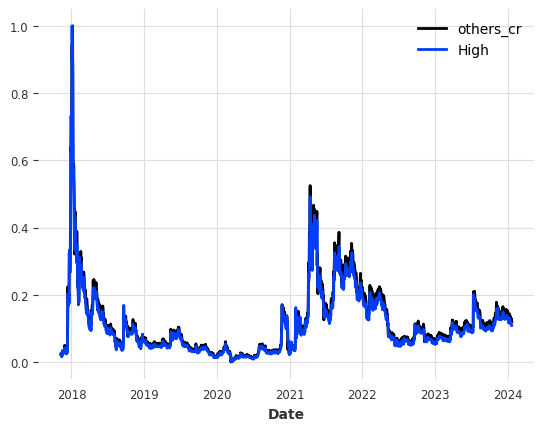

In [15]:
past_covs = concatenate(
    [
        dt_attr(target.time_index, "month", dtype=np.float32),
        dt_attr(target.time_index, "year", dtype=np.float32),
        dt_attr(target.time_index, "day", dtype=np.float32),
        dt_attr(target.time_index, "dayofweek", dtype=np.float32),
        dt_attr(target.time_index, "week", dtype=np.float32),
        dt_attr(target.time_index, "dayofyear", dtype=np.float32),
        covs,
    ],
    axis="component",
)


scaler_ft_past = Scaler()

past_covs = scaler_ft_past.fit_transform(past_covs)
idx = past_covs.columns[6:]
tech_analysis_idx = past_covs[idx.to_list()]
tech_analysis_idx.plot()
plt.show()

In [16]:
future_covs = concatenate(
    [
        dt_attr(target.time_index, "month", dtype=np.float32),
        dt_attr(target.time_index, "year", dtype=np.float32),
        dt_attr(target.time_index, "day", dtype=np.float32),
        dt_attr(target.time_index, "dayofweek", dtype=np.float32),
        dt_attr(target.time_index, "week", dtype=np.float32),
        dt_attr(target.time_index, "dayofyear", dtype=np.float32),
    ],
    axis="component",
)


scaler_ft_future = Scaler()


future_covs = scaler_ft_future.fit_transform(future_covs)

In [17]:
val = scaler_target.inverse_transform(val_scaled)

test = scaler_target.inverse_transform(test_scaled)

# Create csv file where to store all of the Error Metrics

In [18]:
import csv

headers = ['Model', 'MAE', 'RMSE', 'MSE', 'MAPE']
separator = ['-', '-', '-', '-', '-']

with open('./results/error_metrics_XRP.csv', 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the header
    writer.writerow(headers)

def add_row(row):
  with open('./results/error_metrics_XRP.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(row)

# Naive models

In [19]:
models = {}
predictions = {}

models['naive_drift_model'] = NaiveDrift()
models['naive_model'] = NaiveSeasonal()
models['naive_seasonal_model'] = NaiveSeasonal(7)

for key, model in models.items():
    model.fit(train_scaled)
    predictions[key] = model.predict(len(val_scaled))
    predictions[key] = scaler_target.inverse_transform(predictions[key])

In [20]:
print_graph(val, predictions, False, None)

In [21]:
for key, prediction in predictions.items():
    print(f"MAE of {key}: {mae(val, prediction)}")
    print(f"RMSE of {key}: {rmse(val, prediction)}")
    print(f"MSE of {key}: {mse(val, prediction)}")
    print(f"MAPE of {key}: {mape(val, prediction)}")
    print("\n")
    row = [f'{key}', mae(val, prediction), rmse(val, prediction), mse(val, prediction), mape(val, prediction) ]
    add_row(row)

add_row(separator)

MAE of naive_drift_model: 0.02159826084971428
RMSE of naive_drift_model: 0.02926771529018879
MSE of naive_drift_model: 0.0008565991884097457
MAPE of naive_drift_model: 5.599615350365639


MAE of naive_model: 0.02219831943511963
RMSE of naive_model: 0.030246421694755554
MSE of naive_model: 0.0009148460230790079
MAPE of naive_model: 5.749844387173653


MAE of naive_seasonal_model: 0.023113101720809937
RMSE of naive_seasonal_model: 0.029135599732398987
MSE of naive_seasonal_model: 0.0008488831226713955
MAPE of naive_seasonal_model: 6.0528673231601715




# Backtesting Naive Drift Model

In [22]:
bt_horizons = [1, 7 ,30]
bt_start=test_target.time_index[0]


In [23]:
backtesting_Drift = []
backtesting_Naive = []
backtesting_NaiveSeasonal = []
backtesting_ExpSmoothing = []
backtesting_Arima = []
backtesting_Prophet = []
backtesting_Tbats = []

In [24]:

for h in bt_horizons:
  hist_Drift = models['naive_drift_model'].historical_forecasts(
          target_scaled,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
    )
  hist_predict_Drift = scaler_target.inverse_transform(hist_Drift)
  backtesting_Drift.append(hist_predict_Drift)

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

In [25]:
len(backtesting_Drift)

3

In [26]:
for b in backtesting_Drift:
  h = bt_horizons[backtesting_Drift.index(b)]
  print_graph_backtesting(test, b, True, 'naive_drift_model',h)

In [27]:
add_row(['Backtesting Naive Drift Model','','','',''])
for b in backtesting_Drift:
  print(f"MAE of Naive Drift Model forecasting horizon = {bt_horizons[backtesting_Drift.index(b)]}: {mae(test, b)}")
  print(f"RMSE of Naive Drift Model forecasting horizon = {bt_horizons[backtesting_Drift.index(b)]}: {rmse(test, b)}")
  print(f"MSE of Naive Drift Model forecasting horizon = {bt_horizons[backtesting_Drift.index(b)]}: {mse(test, b)}")
  print(f"MAPE of Naive Drift Model forecasting horizon = {bt_horizons[backtesting_Drift.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'Naive Drift fh={bt_horizons[backtesting_Drift.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of Naive Drift Model forecasting horizon = 1: 0.011774147860705853
RMSE of Naive Drift Model forecasting horizon = 1: 0.024351608008146286
MSE of Naive Drift Model forecasting horizon = 1: 0.00059300079010427
MAPE of Naive Drift Model forecasting horizon = 1: 2.162610925734043


MAE of Naive Drift Model forecasting horizon = 7: 0.033203139901161194
RMSE of Naive Drift Model forecasting horizon = 7: 0.055903565138578415
MSE of Naive Drift Model forecasting horizon = 7: 0.0031252086628228426
MAPE of Naive Drift Model forecasting horizon = 7: 5.923911556601524


MAE of Naive Drift Model forecasting horizon = 30: 0.08025171607732773
RMSE of Naive Drift Model forecasting horizon = 30: 0.10891472548246384
MSE of Naive Drift Model forecasting horizon = 30: 0.011862417683005333
MAPE of Naive Drift Model forecasting horizon = 30: 14.344613254070282




# Backtesting Naive Model

In [28]:
for h in bt_horizons:
  hist_Naive = models['naive_model'].historical_forecasts(
          target_scaled,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
    )
  hist_predict_Naive = scaler_target.inverse_transform(hist_Naive)
  backtesting_Naive.append(hist_predict_Naive)

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

In [29]:
for b in backtesting_Naive:
  h = bt_horizons[backtesting_Naive.index(b)]
  print_graph_backtesting(test, b, True, 'naive_model',h)

In [30]:
add_row(['Backtesting Naive Model','','','',''])
for b in backtesting_Naive:
  print(f"MAE of Naive Model forecasting horizon = {bt_horizons[backtesting_Naive.index(b)]}: {mae(test, b)}")
  print(f"RMSE of Naive Model forecasting horizon = {bt_horizons[backtesting_Naive.index(b)]}: {rmse(test, b)}")
  print(f"MSE of Naive Model forecasting horizon = {bt_horizons[backtesting_Naive.index(b)]}: {mse(test, b)}")
  print(f"MAPE of Naive Model forecasting horizon = {bt_horizons[backtesting_Naive.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'Naive fh={bt_horizons[backtesting_Naive.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of Naive Model forecasting horizon = 1: 0.011765480041503906
RMSE of Naive Model forecasting horizon = 1: 0.024347122758626938
MSE of Naive Model forecasting horizon = 1: 0.0005927823949605227
MAPE of Naive Model forecasting horizon = 1: 2.160918340086937


MAE of Naive Model forecasting horizon = 7: 0.03302779793739319
RMSE of Naive Model forecasting horizon = 7: 0.055845968425273895
MSE of Naive Model forecasting horizon = 7: 0.003118772292509675
MAPE of Naive Model forecasting horizon = 7: 5.888755619525909


MAE of Naive Model forecasting horizon = 30: 0.07968728244304657
RMSE of Naive Model forecasting horizon = 30: 0.10867641866207123
MSE of Naive Model forecasting horizon = 30: 0.011810563504695892
MAPE of Naive Model forecasting horizon = 30: 14.185318350791931




# Backtesting Naive Seasonal Model

In [31]:
for h in bt_horizons:
  hist_NaiveSeasonal = models['naive_seasonal_model'].historical_forecasts(
          target_scaled,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
    )
  hist_predict_NaiveSeasonal = scaler_target.inverse_transform(hist_NaiveSeasonal)
  backtesting_NaiveSeasonal.append(hist_predict_NaiveSeasonal)

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

In [32]:
for b in backtesting_NaiveSeasonal:
  h = bt_horizons[backtesting_NaiveSeasonal.index(b)]
  print_graph_backtesting(test, b, True, 'naive_seasonal_model',h)

In [33]:
add_row(['Backtesting Naive Seasonal Model','','','',''])
for b in backtesting_NaiveSeasonal:
  print(f"MAE of Naive Seasonal Model forecasting horizon = {bt_horizons[backtesting_NaiveSeasonal.index(b)]}: {mae(test, b)}")
  print(f"RMSE of Naive Seasonal Model forecasting horizon = {bt_horizons[backtesting_NaiveSeasonal.index(b)]}: {rmse(test, b)}")
  print(f"MSE of Naive Seasonal Model forecasting horizon = {bt_horizons[backtesting_NaiveSeasonal.index(b)]}: {mse(test, b)}")
  print(f"MAPE of Naive Seasonal Model forecasting horizon = {bt_horizons[backtesting_NaiveSeasonal.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'Naive Seasonal fh={bt_horizons[backtesting_NaiveSeasonal.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of Naive Seasonal Model forecasting horizon = 1: 0.032808370888233185
RMSE of Naive Seasonal Model forecasting horizon = 1: 0.055474571883678436
MSE of Naive Seasonal Model forecasting horizon = 1: 0.00307742808945477
MAPE of Naive Seasonal Model forecasting horizon = 1: 5.869567394256592


MAE of Naive Seasonal Model forecasting horizon = 7: 0.03302779793739319
RMSE of Naive Seasonal Model forecasting horizon = 7: 0.055845968425273895
MSE of Naive Seasonal Model forecasting horizon = 7: 0.003118772292509675
MAPE of Naive Seasonal Model forecasting horizon = 7: 5.888755619525909


MAE of Naive Seasonal Model forecasting horizon = 30: 0.08601409196853638
RMSE of Naive Seasonal Model forecasting horizon = 30: 0.11209803819656372
MSE of Naive Seasonal Model forecasting horizon = 30: 0.012565970420837402
MAPE of Naive Seasonal Model forecasting horizon = 30: 15.432688593864441




# Graphs of the Naive Models for each of the 3 forecast horizons (1 day, 7 days, 30 days)

In [49]:
predictions_naive_1= {}
predictions_naive_7= {}
predictions_naive_30= {}

naive_models = ['Naive', 'Naive Drift', 'Naive Seasonal']
backtesting_naive =[backtesting_Naive, backtesting_Drift, backtesting_NaiveSeasonal]
predictions_naive = [predictions_naive_1, predictions_naive_7, predictions_naive_30]

for i in predictions_naive:
    for j in naive_models:
        i[j] = backtesting_naive[naive_models.index(j)][predictions_naive.index(i)]

In [50]:
#print

print_graph_backtesting(test, predictions_naive_1, False, None, 1)
print_graph_backtesting(test, predictions_naive_7, False, None, 7)
print_graph_backtesting(test, predictions_naive_30, False, None, 30)


# Random Forest

In [51]:
from darts.models import RandomForest

random_forest_model = RandomForest(
    lags=[-i for i in range(1, 31)] + [-90, -180],  # Short-term and long-term lags
    lags_past_covariates=[-i for i in range(1, 31)],
    n_estimators=100,  # Number of trees in the forest
    max_depth=15,  # Maximum depth of each tree
)

In [52]:
random_forest_model.fit(train_scaled, past_covariates = past_covs)
random_forest_prediction = random_forest_model.predict(n = len(val_scaled))
random_forest_prediction = scaler_target.inverse_transform(random_forest_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [53]:
print_graph(val, random_forest_prediction, True, 'Random Forest')

In [54]:
print(f"MAE of Random Forest: {mae(val, random_forest_prediction)}")
print(f"RMSE of Random Forest: {rmse(val, random_forest_prediction)}")
print(f"MSE of Random Forest: {mse(val, random_forest_prediction)}")
print(f"MAPE of Random Forest: {mape(val, random_forest_prediction)}")
row = ['Random Forest', mae(val, random_forest_prediction), rmse(val, random_forest_prediction), mse(val, random_forest_prediction), mape(val, random_forest_prediction) ]
add_row(row)
add_row(separator)

MAE of Random Forest: 0.011059886895885386
RMSE of Random Forest: 0.01480160110158056
MSE of Random Forest: 0.0002190873951703108
MAPE of Random Forest: 2.9686324201558807


# Backtesting Random Forest

In [55]:
backtesting_RF = []

bt_horizons = [1, 7 ,30]

bt_start=test.time_index[0]

for h in bt_horizons:

  hist_RF = random_forest_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_RF = scaler_target.inverse_transform(hist_RF)
  backtesting_RF.append(hist_predict_RF)

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/359 [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/336 [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [56]:
for b in backtesting_RF:
  h = bt_horizons[backtesting_RF.index(b)]
  print_graph_backtesting(test, b, True, 'Random Forest',h)

In [57]:
add_row(['Backtesting Random Forest','','','',''])
for b in backtesting_RF:
  print(f"MAE of RF forecasting horizon = {bt_horizons[backtesting_RF.index(b)]}: {mae(test, b)}")
  print(f"RMSE of RF forecasting horizon = {bt_horizons[backtesting_RF.index(b)]}: {rmse(test, b)}")
  print(f"MSE of RF forecasting horizon = {bt_horizons[backtesting_RF.index(b)]}: {mse(test, b)}")
  print(f"MAPE of RF forecasting horizon = {bt_horizons[backtesting_RF.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'Random Forest fh={bt_horizons[backtesting_RF.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of RF forecasting horizon = 1: 0.01866236301786321
RMSE of RF forecasting horizon = 1: 0.030321545786261478
MSE of RF forecasting horizon = 1: 0.0009193961388683512
MAPE of RF forecasting horizon = 1: 3.4320580898861355


MAE of RF forecasting horizon = 7: 0.020459895903452763
RMSE of RF forecasting horizon = 7: 0.031031707034980312
MSE of RF forecasting horizon = 7: 0.0009629668415048466
MAPE of RF forecasting horizon = 7: 3.778755289568539


MAE of RF forecasting horizon = 30: 0.0211802109424943
RMSE of RF forecasting horizon = 30: 0.03191215068815022
MSE of RF forecasting horizon = 30: 0.0010183853615432063
MAPE of RF forecasting horizon = 30: 3.86753558810418




# LSTM Model

Best parameters: {'hidden_dim': 104,
 'r_rnn_layers': 4,
 'dropout': 0.18390991552139796,
 'lr': 0.00014678997505613995,
 'encoders': False}

In [59]:
LSTM_model = BlockRNNModel(
    input_chunk_length=21,
    output_chunk_length=7,
    hidden_dim=104,
    model='LSTM',
    n_rnn_layers=4,
    dropout=0.18390991552139796,
    optimizer_kwargs={'lr': 0.00014678997505613995},
    pl_trainer_kwargs={
        "callbacks": [EarlyStopping(monitor="val_loss", patience=10, min_delta=0.001)]
    },
)

In [60]:
LSTM_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
    val_series = val_scaled,
    val_past_covariates = past_covs,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 309 K 
4 | fc            | Sequential       | 735   
---------------------------------------------------
310 K     Trainable params
0         Non-trainable

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

BlockRNNModel(model=LSTM, hidden_dim=104, n_rnn_layers=4, hidden_fc_sizes=None, dropout=0.18390991552139796, input_chunk_length=21, output_chunk_length=7, optimizer_kwargs={'lr': 0.00014678997505613995}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x0000028A5B90F490>]})

In [61]:
LSTM_model_prediction = LSTM_model.predict(n = len(val_scaled))
LSTM_model_prediction = scaler_target.inverse_transform(LSTM_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [62]:
print_graph(val, LSTM_model_prediction, True, 'LSTM model')

In [63]:
print(f"MAE of LSTM: {mae(val, LSTM_model_prediction)}")
print(f"RMSE of LSTM: {rmse(val, LSTM_model_prediction)}")
print(f"MSE of LSTM: {mse(val, LSTM_model_prediction)}")
print(f"MAPE of LSTM: {mape(val, LSTM_model_prediction)}")
row = ['LSTM', mae(val, LSTM_model_prediction), rmse(val, LSTM_model_prediction), mse(val, LSTM_model_prediction), mape(val, LSTM_model_prediction) ]
add_row(row)
add_row(separator)

MAE of LSTM: 0.025367753580212593
RMSE of LSTM: 0.02861136570572853
MSE of LSTM: 0.0008186102495528758
MAPE of LSTM: 6.961303204298019


# Backtesting LSTM

In [64]:
backtesting_LSTM = []

for h in bt_horizons:

  hist_LSTM = LSTM_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_LSTM = scaler_target.inverse_transform(hist_LSTM)
  backtesting_LSTM.append(hist_predict_LSTM)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [65]:
for b in backtesting_LSTM:
  h = bt_horizons[backtesting_LSTM.index(b)]
  print_graph_backtesting(test, b, True, 'LSTM model',h)

In [66]:
add_row(['Backtesting LSTM Model','','','',''])
for b in backtesting_LSTM:
  print(f"MAE of LSTM forecasting horizon = {bt_horizons[backtesting_LSTM.index(b)]}: {mae(test, b)}")
  print(f"RMSE of LSTM forecasting horizon = {bt_horizons[backtesting_LSTM.index(b)]}: {rmse(test, b)}")
  print(f"MSE of LSTM forecasting horizon = {bt_horizons[backtesting_LSTM.index(b)]}: {mse(test, b)}")
  print(f"MAPE of LSTM forecasting horizon = {bt_horizons[backtesting_LSTM.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'LSTM fh={bt_horizons[backtesting_LSTM.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of LSTM forecasting horizon = 1: 0.03933646157383919
RMSE of LSTM forecasting horizon = 1: 0.054605621844530106
MSE of LSTM forecasting horizon = 1: 0.002981774043291807
MAPE of LSTM forecasting horizon = 1: 7.41034597158432


MAE of LSTM forecasting horizon = 7: 0.05635093152523041
RMSE of LSTM forecasting horizon = 7: 0.07569250464439392
MSE of LSTM forecasting horizon = 7: 0.00572935538366437
MAPE of LSTM forecasting horizon = 7: 10.519010573625565


MAE of LSTM forecasting horizon = 30: 0.059041827917099
RMSE of LSTM forecasting horizon = 30: 0.07940322160720825
MSE of LSTM forecasting horizon = 30: 0.006304871290922165
MAPE of LSTM forecasting horizon = 30: 10.903633385896683




# VanillaRNN Model

Best parameters:
{'hidden_dim': 31,
 'n_rnn_layers': 1,
 'dropout': 0.34008569567908437,
 'lr': 0.0009241588491743642,
 'encoders': False}

In [67]:
vanillaRNN_model = BlockRNNModel(
    input_chunk_length=21,
    output_chunk_length=7,
    model='RNN',
    hidden_dim=31,
    n_rnn_layers=1,
    dropout=0.34008569567908437,
    optimizer_kwargs={'lr': 0.0009241588491743642},
    pl_trainer_kwargs={
        "callbacks": [EarlyStopping(monitor="val_loss", patience=10, min_delta=0.001)]
    },
)

In [68]:
vanillaRNN_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
    val_series = val_scaled,
    val_past_covariates = past_covs,
)

c:\Users\mirja\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.34008569567908437 and num_layers=1

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 1.3 K 
4 | fc            | Sequential       | 224   
---------------------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

BlockRNNModel(model=RNN, hidden_dim=31, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.34008569567908437, input_chunk_length=21, output_chunk_length=7, optimizer_kwargs={'lr': 0.0009241588491743642}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x0000028BF6051890>]})

In [69]:
vanillaRNN_model_prediction = vanillaRNN_model.predict(n = len(val_scaled))
vanillaRNN_model_prediction = scaler_target.inverse_transform(vanillaRNN_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [70]:
print_graph(val, vanillaRNN_model_prediction, True, 'Vanilla RNN')

In [71]:
print(f"MAE of VanillaRNN: {mae(val, vanillaRNN_model_prediction)}")
print(f"RMSE of VanillaRNN: {rmse(val, vanillaRNN_model_prediction)}")
print(f"MSE of VanillaRNN: {mse(val, vanillaRNN_model_prediction)}")
print(f"MAPE of VanillaRNN: {mape(val, vanillaRNN_model_prediction)}")
row = ['VanillaRNN', mae(val, vanillaRNN_model_prediction), rmse(val, vanillaRNN_model_prediction), mse(val, vanillaRNN_model_prediction), mape(val, vanillaRNN_model_prediction)]
add_row(row)
add_row(separator)

MAE of VanillaRNN: 0.039358172565698624
RMSE of VanillaRNN: 0.0643223375082016
MSE of VanillaRNN: 0.004137362819164991
MAPE of VanillaRNN: 11.174125224351883


# Backtesting VanillaRNN

In [72]:
backtesting_VanillaRNN = []

for h in bt_horizons:

  hist_VanillaRNN = vanillaRNN_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_VanillaRNN = scaler_target.inverse_transform(hist_VanillaRNN)
  backtesting_VanillaRNN.append(hist_predict_VanillaRNN)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [73]:
for b in backtesting_VanillaRNN:
  h = bt_horizons[backtesting_VanillaRNN.index(b)]
  print_graph_backtesting(test, b, True, 'Vanilla RNN',h)

In [74]:
add_row(['Backtesting RNN Model','','','',''])
for b in backtesting_VanillaRNN:
  print(f"MAE of RNN forecasting horizon = {bt_horizons[backtesting_VanillaRNN.index(b)]}: {mae(test, b)}")
  print(f"RMSE of RNN forecasting horizon = {bt_horizons[backtesting_VanillaRNN.index(b)]}: {rmse(test, b)}")
  print(f"MSE of RNN forecasting horizon = {bt_horizons[backtesting_VanillaRNN.index(b)]}: {mse(test, b)}")
  print(f"MAPE of RNN forecasting horizon = {bt_horizons[backtesting_VanillaRNN.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'RNN fh={bt_horizons[backtesting_VanillaRNN.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of RNN forecasting horizon = 1: 0.02056432142853737
RMSE of RNN forecasting horizon = 1: 0.03199564293026924
MSE of RNN forecasting horizon = 1: 0.001023721182718873
MAPE of RNN forecasting horizon = 1: 3.787795826792717


MAE of RNN forecasting horizon = 7: 0.03864017128944397
RMSE of RNN forecasting horizon = 7: 0.05845044553279877
MSE of RNN forecasting horizon = 7: 0.003416454652324319
MAPE of RNN forecasting horizon = 7: 6.990911811590195


MAE of RNN forecasting horizon = 30: 0.04323575645685196
RMSE of RNN forecasting horizon = 30: 0.06206859275698662
MSE of RNN forecasting horizon = 30: 0.0038525101263076067
MAPE of RNN forecasting horizon = 30: 7.780900597572327




# GRU Model

Best parameters: {'hidden_dim': 75,
 'r_rnn_layers': 1,
 'dropout': 0.007824503730612165,
 'lr': 0.000566687831423731,
 'encoders': False}

In [75]:
GRU_model = BlockRNNModel(
    input_chunk_length=21,
    output_chunk_length=7,
    model='GRU',
    hidden_dim=75,
    n_rnn_layers=1,
    dropout=0.007824503730612165,
    optimizer_kwargs={'lr': 0.000566687831423731},
    pl_trainer_kwargs={
        "callbacks": [EarlyStopping(monitor="val_loss", patience=10, min_delta=0.001)]
    },
)

In [76]:
GRU_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
    val_series = val_scaled,
    val_past_covariates = past_covs,
)

c:\Users\mirja\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.007824503730612165 and num_layers=1

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | GRU              | 19.4 K
4 | fc            | Sequential       | 532   
---------------------------------------------------
19.9 K    Trainable params
0         Non-trainable params
19.9 K    Total params
0.080     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

BlockRNNModel(model=GRU, hidden_dim=75, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.007824503730612165, input_chunk_length=21, output_chunk_length=7, optimizer_kwargs={'lr': 0.000566687831423731}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x0000028BE0EC6FD0>]})

In [77]:
GRU_model_prediction = GRU_model.predict(n = len(val_scaled))
GRU_model_prediction = scaler_target.inverse_transform(GRU_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [78]:
print_graph(val, GRU_model_prediction, True, 'GRU Model')

In [79]:
print(f"MAE of GRU: {mae(val, GRU_model_prediction)}")
print(f"RMSE of GRU: {rmse(val, GRU_model_prediction)}")
print(f"MSE of GRU: {mse(val, GRU_model_prediction)}")
print(f"MAPE of GRU: {mape(val, GRU_model_prediction)}")
row = ['GRU Model', mae(val, GRU_model_prediction), rmse(val, GRU_model_prediction), mse(val, GRU_model_prediction), mape(val, GRU_model_prediction) ]
add_row(row)
add_row(separator)

MAE of GRU: 0.03676464036107063
RMSE of GRU: 0.04961511120200157
MSE of GRU: 0.0024616592563688755
MAPE of GRU: 10.374245792627335


# Backtesting GRU

In [80]:
backtesting_GRU = []

for h in bt_horizons:

  hist_GRU = GRU_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_GRU = scaler_target.inverse_transform(hist_GRU)
  backtesting_GRU.append(hist_predict_GRU)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [81]:
for b in backtesting_GRU:
  h = bt_horizons[backtesting_GRU.index(b)]
  print_graph_backtesting(test, b, True, 'GRU model',h)

In [82]:
add_row(['Backtesting GRU Model','','','',''])
for b in backtesting_GRU:
  print(f"MAE of GRU forecasting horizon = {bt_horizons[backtesting_GRU.index(b)]}: {mae(test, b)}")
  print(f"RMSE of GRU forecasting horizon = {bt_horizons[backtesting_GRU.index(b)]}: {rmse(test, b)}")
  print(f"MSE of GRU forecasting horizon = {bt_horizons[backtesting_GRU.index(b)]}: {mse(test, b)}")
  print(f"MAPE of GRU forecasting horizon = {bt_horizons[backtesting_GRU.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'GRU fh={bt_horizons[backtesting_GRU.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of GRU forecasting horizon = 1: 0.02071433886885643
RMSE of GRU forecasting horizon = 1: 0.03420480340719223
MSE of GRU forecasting horizon = 1: 0.001169968512840569
MAPE of GRU forecasting horizon = 1: 3.8019105792045593


MAE of GRU forecasting horizon = 7: 0.05613002926111221
RMSE of GRU forecasting horizon = 7: 0.07563268393278122
MSE of GRU forecasting horizon = 7: 0.0057203033939003944
MAPE of GRU forecasting horizon = 7: 10.129600018262863


MAE of GRU forecasting horizon = 30: 0.0696987584233284
RMSE of GRU forecasting horizon = 30: 0.08826401829719543
MSE of GRU forecasting horizon = 30: 0.0077905370853841305
MAPE of GRU forecasting horizon = 30: 12.525789439678192




# Transformer Model

Best params: {'d_model': 88, 'nhead': 4, 'num_encoder_layers': 4, 'num_decoder_layers': 1, 'dropout': 0.14295488378943239, 'lr': 0.00046254166100837376, 'encoders': False}

In [83]:
transformer_model = TransformerModel(
    input_chunk_length = 21,
    output_chunk_length = 7,
    d_model=88,
    nhead=4,
    num_encoder_layers=4,
    num_decoder_layers=1,
    dropout=0.14295488378943239,
    optimizer_kwargs={'lr': 0.00046254166100837376},
    pl_trainer_kwargs={
        "callbacks": [EarlyStopping(monitor="val_loss", patience=10, min_delta=0.001)]
    },
)

In [84]:
transformer_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
    val_series = val_scaled,
    val_past_covariates = past_covs,
)

c:\Users\mirja\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 880   
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 643 K 
6 | decoder             | Linear              | 623   
------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

TransformerModel(d_model=88, nhead=4, num_encoder_layers=4, num_decoder_layers=1, dim_feedforward=512, dropout=0.14295488378943239, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=21, output_chunk_length=7, optimizer_kwargs={'lr': 0.00046254166100837376}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x0000028BE1834290>]})

In [85]:
transformer_model_prediction = transformer_model.predict(n = len(val_scaled))
transformer_model_prediction = scaler_target.inverse_transform(transformer_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [86]:
print_graph(val, transformer_model_prediction, True, 'Transformer Model')

In [87]:
print(f"MAE of Transformer Model: {mae(val, transformer_model_prediction)}")
print(f"RMSE of Transformer Model: {rmse(val, transformer_model_prediction)}")
print(f"MSE of Transformer Model: {mse(val, transformer_model_prediction)}")
print(f"MAPE of Transformer Model: {mape(val, transformer_model_prediction)}")
row = ['Transformer Model', mae(val, transformer_model_prediction), rmse(val, transformer_model_prediction), mse(val, transformer_model_prediction), mape(val, transformer_model_prediction) ]
add_row(row)
add_row(separator)

MAE of Transformer Model: 0.08320657163858414
RMSE of Transformer Model: 0.09698802977800369
MSE of Transformer Model: 0.009406677447259426
MAPE of Transformer Model: 22.387824952602386


# Backtesting Transformer Model

In [88]:
backtesting_Transformer = []

for h in bt_horizons:

  hist_Transformer = transformer_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_Transformer = scaler_target.inverse_transform(hist_Transformer)
  backtesting_Transformer.append(hist_predict_Transformer)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [89]:
for b in backtesting_Transformer:
  h = bt_horizons[backtesting_Transformer.index(b)]
  print_graph_backtesting(test, b, True, 'Transformer Model',h)

In [90]:
add_row(['Backtesting Transformer Model','','','',''])
for b in backtesting_Transformer:
  print(f"MAE of Transformer Model forecasting horizon = {bt_horizons[backtesting_Transformer.index(b)]}: {mae(test, b)}")
  print(f"RMSE of Transformer Model forecasting horizon = {bt_horizons[backtesting_Transformer.index(b)]}: {rmse(test, b)}")
  print(f"MSE of Transformer Model forecasting horizon = {bt_horizons[backtesting_Transformer.index(b)]}: {mse(test, b)}")
  print(f"MAPE of Transformer Model forecasting horizon = {bt_horizons[backtesting_Transformer.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'Transformer fh={bt_horizons[backtesting_Transformer.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of Transformer Model forecasting horizon = 1: 0.08670441806316376
RMSE of Transformer Model forecasting horizon = 1: 0.09592323750257492
MSE of Transformer Model forecasting horizon = 1: 0.00920126773416996
MAPE of Transformer Model forecasting horizon = 1: 16.408000886440277


MAE of Transformer Model forecasting horizon = 7: 0.05081431195139885
RMSE of Transformer Model forecasting horizon = 7: 0.07369773834943771
MSE of Transformer Model forecasting horizon = 7: 0.0054313563741743565
MAPE of Transformer Model forecasting horizon = 7: 8.971250057220459


MAE of Transformer Model forecasting horizon = 30: 0.07758595794439316
RMSE of Transformer Model forecasting horizon = 30: 0.09993943572044373
MSE of Transformer Model forecasting horizon = 30: 0.009987890720367432
MAPE of Transformer Model forecasting horizon = 30: 13.57625275850296




# TFT Model

best parameters: {'hidden_size': 30,
 'lstm_layers': 1,
 'num_attention_heads': 4,
 'dropout': 0.06118422728497173,
 'hidden_continuous_size': 10,
 'lr': 0.005081664304452033}

In [91]:
TFT_model = TFTModel(
    input_chunk_length=21,
    output_chunk_length=7,
    hidden_size=30,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.06118422728497173,
    hidden_continuous_size=10,
    optimizer_kwargs={'lr': 0.005081664304452033},
)

In [92]:
TFT_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
    future_covariates = future_covs
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 19.3 K
5  | decoder_vsn                       | _VariableSelectionNetwork        | 7.0 K 
6  | static_context_grn                | _GatedResidualNetwork            | 3.8 K 
7  | static_context_hidden_encoder_grn | _GatedResid

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


TFTModel(hidden_size=30, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.06118422728497173, hidden_continuous_size=10, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=21, output_chunk_length=7, optimizer_kwargs={'lr': 0.005081664304452033})

In [93]:
TFT_model_prediction = TFT_model.predict(n = len(val_scaled))
TFT_model_prediction = scaler_target.inverse_transform(TFT_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [94]:
print_graph(val, TFT_model_prediction, True, 'TFT Model')

In [95]:
print(f"MAE of TFT Model: {mae(val, TFT_model_prediction)}")
print(f"RMSE of TFT Model: {rmse(val, TFT_model_prediction)}")
print(f"MSE of TFT Model: {mse(val, TFT_model_prediction)}")
print(f"MAPE of TFT Model: {mape(val, TFT_model_prediction)}")
row = ['TFT', mae(val, TFT_model_prediction), rmse(val, TFT_model_prediction), mse(val, TFT_model_prediction), mape(val, TFT_model_prediction) ]
add_row(row)
add_row(separator)

MAE of TFT Model: 0.024359043687582016
RMSE of TFT Model: 0.028942443430423737
MSE of TFT Model: 0.0008376650512218475
MAPE of TFT Model: 6.548399478197098


# Backtesting TFT Model

In [96]:
backtesting_TFT = []

for h in bt_horizons:

  hist_TFT = TFT_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          future_covariates = future_covs,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_TFT = scaler_target.inverse_transform(hist_TFT)
  backtesting_TFT.append(hist_predict_TFT)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [97]:
for b in backtesting_TFT:
  h = bt_horizons[backtesting_TFT.index(b)]
  print_graph_backtesting(test, b, True, 'TFT Model',h)

In [98]:
add_row(['Backtesting TFT Model','','','',''])
for b in backtesting_TFT:
  print(f"MAE of TFT Model forecasting horizon = {bt_horizons[backtesting_TFT.index(b)]}: {mae(test, b)}")
  print(f"RMSE of TFT Model forecasting horizon = {bt_horizons[backtesting_TFT.index(b)]}: {rmse(test, b)}")
  print(f"MSE of TFT Model forecasting horizon = {bt_horizons[backtesting_TFT.index(b)]}: {mse(test, b)}")
  print(f"MAPE of TFT Model forecasting horizon = {bt_horizons[backtesting_TFT.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'TFT fh={bt_horizons[backtesting_TFT.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of TFT Model forecasting horizon = 1: 0.05793701484799385
RMSE of TFT Model forecasting horizon = 1: 0.07371002435684204
MSE of TFT Model forecasting horizon = 1: 0.005433167330920696
MAPE of TFT Model forecasting horizon = 1: 10.541364550590515


MAE of TFT Model forecasting horizon = 7: 0.0886411964893341
RMSE of TFT Model forecasting horizon = 7: 0.1157262995839119
MSE of TFT Model forecasting horizon = 7: 0.013392576016485691
MAPE of TFT Model forecasting horizon = 7: 16.09768569469452


MAE of TFT Model forecasting horizon = 30: 0.0952649787068367
RMSE of TFT Model forecasting horizon = 30: 0.1235230565071106
MSE of TFT Model forecasting horizon = 30: 0.015257946215569973
MAPE of TFT Model forecasting horizon = 30: 17.051737010478973




# NBEATS Model

Best parameters: {'num_stacks': 19,
 'num_blocks': 4,
 'num_layers': 4,
 'layer_widths': 378,
 'expansion_coefficient_dim': 8,
 'dropout': 0.007293860107310261,
 'lr': 0.0005903374698873167,
 'encoders': True}

In [99]:
from darts.models import NBEATSModel

NBEATS_model = NBEATSModel(
    input_chunk_length=21,
    output_chunk_length=7,
    num_stacks=19,
    num_blocks=4,
    num_layers=4,
    layer_widths=378,
    expansion_coefficient_dim=8,
    dropout=0.007293860107310261,
    add_encoders =  {
        'cyclic': {'past': ['month', 'dayofweek', 'dayofyear']},  # Capture seasonal trends
        'datetime_attribute': {'past': ['day', 'week', 'year']},
        'position': {'past': ['relative']},
        'transformer': Scaler(),
    },
    optimizer_kwargs={'lr': 0.0005903374698873167},
    pl_trainer_kwargs={
        "callbacks": [EarlyStopping(monitor="val_loss", patience=10, min_delta=0.001)]
    },
)

In [100]:

NBEATS_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
    val_series = val_scaled,
    val_past_covariates = past_covs,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 45.0 M
---------------------------------------------------
45.0 M    Trainable params
6.6 K     Non-trainable params
45.0 M    Total params
179.919   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

NBEATSModel(generic_architecture=True, num_stacks=19, num_blocks=4, num_layers=4, layer_widths=378, expansion_coefficient_dim=8, trend_polynomial_degree=2, dropout=0.007293860107310261, activation=ReLU, input_chunk_length=21, output_chunk_length=7, add_encoders={'cyclic': {'past': ['month', 'dayofweek', 'dayofyear']}, 'datetime_attribute': {'past': ['day', 'week', 'year']}, 'position': {'past': ['relative']}, 'transformer': Scaler}, optimizer_kwargs={'lr': 0.0005903374698873167}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x0000028BF6512910>]})

In [101]:
NBEATS_model_prediction = NBEATS_model.predict(n=len(val_scaled))
NBEATS_model_prediction = scaler_target.inverse_transform(NBEATS_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [102]:
print_graph(val, NBEATS_model_prediction, True, 'NBEATS Model')

In [103]:
print(f"MAE of NBEATS: {mae(val, NBEATS_model_prediction)}")
print(f"RMSE of NBEATS: {rmse(val, NBEATS_model_prediction)}")
print(f"MSE of NBEATS: {mse(val, NBEATS_model_prediction)}")
print(f"MAPE of NBEATS: {mape(val, NBEATS_model_prediction)}")
row = ['NBEATS', mae(val, NBEATS_model_prediction), rmse(val, NBEATS_model_prediction), mse(val, NBEATS_model_prediction), mape(val, NBEATS_model_prediction) ]
add_row(row)
add_row(separator)

MAE of NBEATS: 0.04292140528559685
RMSE of NBEATS: 0.052168454974889755
MSE of NBEATS: 0.0027215476147830486
MAPE of NBEATS: 11.912058293819427


# Backtesting NBEATS Model

In [104]:
backtesting_NBEATS = []

for h in bt_horizons:

  hist_NBEATS = NBEATS_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_NBEATS = scaler_target.inverse_transform(hist_NBEATS)
  backtesting_NBEATS.append(hist_predict_NBEATS)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [105]:
for b in backtesting_NBEATS:
  h = bt_horizons[backtesting_NBEATS.index(b)]
  print_graph_backtesting(test, b, True, 'NBEATS Model',h)

In [106]:
add_row(['Backtesting NBEATS Model','','','',''])
for b in backtesting_NBEATS:
  print(f"MAE of NBEATS Model forecasting horizon = {bt_horizons[backtesting_NBEATS.index(b)]}: {mae(test, b)}")
  print(f"RMSE of NBEATS Model forecasting horizon = {bt_horizons[backtesting_NBEATS.index(b)]}: {rmse(test, b)}")
  print(f"MSE of NBEATS Model forecasting horizon = {bt_horizons[backtesting_NBEATS.index(b)]}: {mse(test, b)}")
  print(f"MAPE of NBEATS Model forecasting horizon = {bt_horizons[backtesting_NBEATS.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'NBEATS fh={bt_horizons[backtesting_NBEATS.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of NBEATS Model forecasting horizon = 1: 0.045352958142757416
RMSE of NBEATS Model forecasting horizon = 1: 0.06131371483206749
MSE of NBEATS Model forecasting horizon = 1: 0.003759371815249324
MAPE of NBEATS Model forecasting horizon = 1: 8.649639040231705


MAE of NBEATS Model forecasting horizon = 7: 0.09656663984060287
RMSE of NBEATS Model forecasting horizon = 7: 0.12759824097156525
MSE of NBEATS Model forecasting horizon = 7: 0.016281312331557274
MAPE of NBEATS Model forecasting horizon = 7: 19.447273015975952


MAE of NBEATS Model forecasting horizon = 30: 0.11131822317838669
RMSE of NBEATS Model forecasting horizon = 30: 0.14682190120220184
MSE of NBEATS Model forecasting horizon = 30: 0.0215566698461771
MAPE of NBEATS Model forecasting horizon = 30: 21.704137325286865




# TCN Model

Best parameters: {'kernel_size': 8,
 'num_filters': 36,
 'weight_norm': False,
 'dilation_base': 2,
 'dropout': 0.14321708644925318,
 'lr': 0.0005056311276120884,
 'encoders': True}

In [107]:
TCN_model = TCNModel(
    input_chunk_length=21,
    output_chunk_length=7,
    kernel_size=8,
    num_filters=36,
    weight_norm= False,
    dilation_base=2,
    dropout= 0.14321708644925318,
    optimizer_kwargs={'lr': 0.0005056311276120884},
    random_state=0,
    add_encoders = {
        'cyclic': {'past': ['month', 'dayofweek', 'dayofyear']},  # Capture seasonal trends
        'datetime_attribute': {'past': ['day', 'week', 'year']},
        'position': {'past': ['relative']},
        'transformer': Scaler(),
    }
)

In [108]:
TCN_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
    val_series = val_scaled,
    val_past_covariates = past_covs,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 27.4 K
----------------------------------------------------
27.4 K    Trainable params
0         Non-trainable params
27.4 K    Total params
0.109     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


TCNModel(kernel_size=8, num_filters=36, num_layers=None, dilation_base=2, weight_norm=False, dropout=0.14321708644925318, input_chunk_length=21, output_chunk_length=7, optimizer_kwargs={'lr': 0.0005056311276120884}, random_state=0, add_encoders={'cyclic': {'past': ['month', 'dayofweek', 'dayofyear']}, 'datetime_attribute': {'past': ['day', 'week', 'year']}, 'position': {'past': ['relative']}, 'transformer': Scaler})

In [109]:
TCN_model_prediction = TCN_model.predict(n = len(val_scaled))
TCN_model_prediction = scaler_target.inverse_transform(TCN_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [110]:
print_graph(val, TCN_model_prediction, True, 'TCN Model')

In [111]:
print(f"MAE of TCN: {mae(val, TCN_model_prediction)}")
print(f"RMSE of TCN: {rmse(val, TCN_model_prediction)}")
print(f"MSE of TCN: {mse(val, TCN_model_prediction)}")
print(f"MAPE of TCN: {mape(val, TCN_model_prediction)}")
row = ['TCN', mae(val, TCN_model_prediction), rmse(val, TCN_model_prediction), mse(val, TCN_model_prediction), mape(val, TCN_model_prediction) ]
add_row(row)
add_row(separator)

MAE of TCN: 0.038115520030260086
RMSE of TCN: 0.042331863194704056
MSE of TCN: 0.0017919865204021335
MAPE of TCN: 10.450859367847443


# Backtesting TCN Model

In [112]:
backtesting_TCN = []

for h in bt_horizons:

  hist_TCN = TCN_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_TCN = scaler_target.inverse_transform(hist_TCN)
  backtesting_TCN.append(hist_predict_TCN)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [113]:
for b in backtesting_TCN:
  h = bt_horizons[backtesting_TCN.index(b)]
  print_graph_backtesting(test, b, True, 'TCN Model',h)

In [114]:
add_row(['Backtesting TCN Model','','','',''])
for b in backtesting_TCN:
  print(f"MAE of TCN Model forecasting horizon = {bt_horizons[backtesting_TCN.index(b)]}: {mae(test, b)}")
  print(f"RMSE of TCN Model forecasting horizon = {bt_horizons[backtesting_TCN.index(b)]}: {rmse(test, b)}")
  print(f"MSE of TCN Model forecasting horizon = {bt_horizons[backtesting_TCN.index(b)]}: {mse(test, b)}")
  print(f"MAPE of TCN Model forecasting horizon = {bt_horizons[backtesting_TCN.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'TCN fh={bt_horizons[backtesting_TCN.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of TCN Model forecasting horizon = 1: 0.05972501263022423
RMSE of TCN Model forecasting horizon = 1: 0.0856596827507019
MSE of TCN Model forecasting horizon = 1: 0.00733758183196187
MAPE of TCN Model forecasting horizon = 1: 11.530552804470062


MAE of TCN Model forecasting horizon = 7: 0.05802431330084801
RMSE of TCN Model forecasting horizon = 7: 0.08388100564479828
MSE of TCN Model forecasting horizon = 7: 0.007036023307591677
MAPE of TCN Model forecasting horizon = 7: 11.139152199029922


MAE of TCN Model forecasting horizon = 30: 0.06896217912435532
RMSE of TCN Model forecasting horizon = 30: 0.09808222204446793
MSE of TCN Model forecasting horizon = 30: 0.0096201216802001
MAPE of TCN Model forecasting horizon = 30: 12.934476137161255




# Graphs of the DL Models for each of the 3 forecast horizons (1 day, 7 days, 30 days)

In [115]:
predictions_DL_1= {}
predictions_DL_7= {}
predictions_DL_30= {}

DL_models = ['LSTM', 'RNN', 'GRU', 'Transformer', 'TFT', 'NBEATS', 'TCN']
backtesting_DL =[backtesting_LSTM, backtesting_VanillaRNN, backtesting_GRU, backtesting_Transformer, backtesting_TFT, backtesting_NBEATS, backtesting_TCN] 
predictions_DL = [predictions_DL_1, predictions_DL_7, predictions_DL_30]

for i in predictions_DL:
    for j in DL_models:
        i[j] = backtesting_DL[DL_models.index(j)][predictions_DL.index(i)]

In [116]:
print_graph_backtesting(test, predictions_DL_1, False, None, 1)
print_graph_backtesting(test, predictions_DL_7, False, None, 7)
print_graph_backtesting(test, predictions_DL_30, False, None, 30)

# LightGBM Model

In [117]:
from darts.models.forecasting.lgbm import LightGBMModel

LightGBM_model = LightGBMModel(
    lags=[-i for i in range(1, 31)] + [-90, -180],  # Short-term and long-term lags
    lags_past_covariates=[-i for i in range(1, 31)],
    output_chunk_length = 7,
)

In [118]:
LightGBM_model.fit(
    series = train_scaled,
    past_covariates = past_covs,

)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34380
[LightGBM] [Info] Number of data points in the train set: 1687, number of used features: 272
[LightGBM] [Info] Start training from score 0.106203
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34380
[LightGBM] [Info] Number of data points in the train set: 1687, number of used features: 272
[LightGBM] [Info] Start training from score 0.106118
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34380
[LightGBM] [Info] Number of data points in the train set: 1687, number of used features: 272
[LightGBM] [Info] Start 

LightGBMModel(lags=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -90, -180], lags_past_covariates=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30], lags_future_covariates=None, output_chunk_length=7, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True, categorical_past_covariates=None, categorical_future_covariates=None, categorical_static_covariates=None)

In [119]:
LightGBM_model_prediction = LightGBM_model.predict(n = len(val_scaled))
LightGBM_model_prediction = scaler_target.inverse_transform(LightGBM_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [120]:
print_graph(val, LightGBM_model_prediction,True, 'LightGBM Model')

In [121]:
print(f"MAE of LightGBM: {mae(val, LightGBM_model_prediction)}")
print(f"RMSE of LightGBM: {rmse(val, LightGBM_model_prediction)}")
print(f"MSE of LightGBM: {mse(val, LightGBM_model_prediction)}")
print(f"MAPE of LightGBM: {mape(val, LightGBM_model_prediction)}")
row = ['LightGBM', mae(val, LightGBM_model_prediction), rmse(val, LightGBM_model_prediction), mse(val, LightGBM_model_prediction), mape(val, LightGBM_model_prediction) ]
add_row(row)
add_row(separator)

MAE of LightGBM: 0.019390962819407057
RMSE of LightGBM: 0.02313579620733294
MSE of LightGBM: 0.0005352650661472413
MAPE of LightGBM: 5.172103925822264


# Backtesting LightGBM Model

In [122]:
backtesting_LightGBM = []

for h in bt_horizons:
  hist_LightGBM = LightGBM_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )
  hist_predict_LightGBM = scaler_target.inverse_transform(hist_LightGBM)
  backtesting_LightGBM.append(hist_predict_LightGBM)

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/336 [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [123]:
for b in backtesting_LightGBM:
  h = bt_horizons[backtesting_LightGBM.index(b)]
  print_graph_backtesting(test, b, True, 'LightGBM Model',h)

In [124]:
add_row(['Backtesting LightGBM Model','','','',''])
for b in backtesting_LightGBM:
  print(f"MAE of LightGBM forecasting horizon = {bt_horizons[backtesting_LightGBM.index(b)]}: {mae(test, b)}")
  print(f"RMSE of LightGBM forecasting horizon = {bt_horizons[backtesting_LightGBM.index(b)]}: {rmse(test, b)}")
  print(f"MSE of LightGBM forecasting horizon = {bt_horizons[backtesting_LightGBM.index(b)]}: {mse(test, b)}")
  print(f"MAPE of LightGBM forecasting horizon = {bt_horizons[backtesting_LightGBM.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'LightGBM fh={bt_horizons[backtesting_LightGBM.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)


MAE of LightGBM forecasting horizon = 1: 0.021756713333746003
RMSE of LightGBM forecasting horizon = 1: 0.032785659167832125
MSE of LightGBM forecasting horizon = 1: 0.0010748994470692547
MAPE of LightGBM forecasting horizon = 1: 3.9652496259553653


MAE of LightGBM forecasting horizon = 7: 0.07506167110050042
RMSE of LightGBM forecasting horizon = 7: 0.10550454602913126
MSE of LightGBM forecasting horizon = 7: 0.011131209232813076
MAPE of LightGBM forecasting horizon = 7: 13.292645151787926


MAE of LightGBM forecasting horizon = 30: 0.11992584933518351
RMSE of LightGBM forecasting horizon = 30: 0.14994078604018435
MSE of LightGBM forecasting horizon = 30: 0.022482239318348342
MAPE of LightGBM forecasting horizon = 30: 21.264576070323628




# XGB Model

In [125]:
from darts.models import XGBModel

XGB_model = XGBModel (
    lags=[-i for i in range(1, 31)] + [-90, -180],  # Short-term and long-term lags
    lags_past_covariates=[-i for i in range(1, 31)],
    output_chunk_length = 7,
)

In [126]:
XGB_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
)

XGBModel(lags=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -90, -180], lags_past_covariates=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30], lags_future_covariates=None, output_chunk_length=7, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)

In [127]:
XGB_model_prediction = XGB_model.predict(n = len(val))
XGB_model_prediction = scaler_target.inverse_transform(XGB_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [128]:
print_graph(val, XGB_model_prediction, True, 'XGB Model')

In [129]:
print(f"MAE of XGB: {mae(val, XGB_model_prediction)}")
print(f"RMSE of XGB: {rmse(val, XGB_model_prediction)}")
print(f"MSE of XGB: {mse(val, XGB_model_prediction)}")
print(f"MAPE of XGB: {mape(val, XGB_model_prediction)}")
row = ['XGB', mae(val, XGB_model_prediction), rmse(val, XGB_model_prediction), mse(val, XGB_model_prediction), mape(val, XGB_model_prediction) ]
add_row(row)
add_row(separator)

MAE of XGB: 0.016431786119937897
RMSE of XGB: 0.02046866901218891
MSE of XGB: 0.0004189663741271943
MAPE of XGB: 4.389973729848862


# Backtesting XGB Model

In [130]:
backtesting_XGB = []

for h in bt_horizons:

  hist_XGB = XGB_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_XGB = scaler_target.inverse_transform(hist_XGB)
  backtesting_XGB.append(hist_predict_XGB)

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/336 [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [131]:
for b in backtesting_XGB:
  h = bt_horizons[backtesting_XGB.index(b)]
  print_graph_backtesting(test, b, True, 'XGB Model',h)

In [132]:
add_row(['Backtesting XGB Model','','','',''])
for b in backtesting_XGB:
  print(f"MAE of XGB forecasting horizon = {bt_horizons[backtesting_XGB.index(b)]}: {mae(test, b)}")
  print(f"RMSE of XGB forecasting horizon = {bt_horizons[backtesting_XGB.index(b)]}: {rmse(test, b)}")
  print(f"MSE of XGB forecasting horizon = {bt_horizons[backtesting_XGB.index(b)]}: {mse(test, b)}")
  print(f"MAPE of XGB forecasting horizon = {bt_horizons[backtesting_XGB.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'XGB fh={bt_horizons[backtesting_XGB.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of XGB forecasting horizon = 1: 0.0202572513371706
RMSE of XGB forecasting horizon = 1: 0.03234199807047844
MSE of XGB forecasting horizon = 1: 0.0010460048215463758
MAPE of XGB forecasting horizon = 1: 3.6781027913093567


MAE of XGB forecasting horizon = 7: 0.07306477427482605
RMSE of XGB forecasting horizon = 7: 0.09849067032337189
MSE of XGB forecasting horizon = 7: 0.00970041286200285
MAPE of XGB forecasting horizon = 7: 12.832251191139221


MAE of XGB forecasting horizon = 30: 0.10476325452327728
RMSE of XGB forecasting horizon = 30: 0.12922663986682892
MSE of XGB forecasting horizon = 30: 0.016699522733688354
MAPE of XGB forecasting horizon = 30: 18.543431162834167




# CatBoost Model

In [133]:
from darts.models import CatBoostModel

In [134]:
CatBoost_model = CatBoostModel(
    lags=[-i for i in range(1, 31)] + [-90, -180],  # Short-term and long-term lags
    lags_past_covariates=[-i for i in range(1, 31)],
    output_chunk_length = 7,
)

In [135]:
CatBoost_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
)

CatBoostModel(lags=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -90, -180], lags_past_covariates=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30], lags_future_covariates=None, output_chunk_length=7, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)

In [136]:
CatBoost_model_prediction = CatBoost_model.predict(n = len(val))
Catboost_model_prediction = scaler_target.inverse_transform(CatBoost_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [137]:
print_graph(val, Catboost_model_prediction, True, 'CatBoost Model')

In [138]:
print(f"MAE of CatBoost: {mae(val, CatBoost_model_prediction)}")
print(f"RMSE of CatBoost: {rmse(val, CatBoost_model_prediction)}")
print(f"MSE of CatBoost: {mse(val, CatBoost_model_prediction)}")
print(f"MAPE of CatBoost: {mape(val, CatBoost_model_prediction)}")
row = ['CatBoost', mae(val, CatBoost_model_prediction), rmse(val, CatBoost_model_prediction), mse(val, CatBoost_model_prediction), mape(val, CatBoost_model_prediction) ]
add_row(row)
add_row(separator)

MAE of CatBoost: 0.30019961466295764
RMSE of CatBoost: 0.3009045165694578
MSE of CatBoost: 0.09054352809189911
MAPE of CatBoost: 81.9732958557086


# Backtesting CatBoost Model

In [139]:
backtesting_CatBoost = []

for h in bt_horizons:

  hist_CatBoost = CatBoost_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_CatBoost = scaler_target.inverse_transform(hist_CatBoost)
  backtesting_CatBoost.append(hist_predict_CatBoost)

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/336 [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [140]:
for b in backtesting_CatBoost:
  h = bt_horizons[backtesting_CatBoost.index(b)]
  print_graph_backtesting(test, b, True, 'CatBoost Model',h)

In [141]:
add_row(['Backtesting Catboost Model','','','',''])
for b in backtesting_CatBoost:
  print(f"MAE of CatBoost forecasting horizon = {bt_horizons[backtesting_CatBoost.index(b)]}: {mae(test, b)}")
  print(f"RMSE of CatBoost forecasting horizon = {bt_horizons[backtesting_CatBoost.index(b)]}: {rmse(test, b)}")
  print(f"MSE of CatBoost forecasting horizon = {bt_horizons[backtesting_CatBoost.index(b)]}: {mse(test, b)}")
  print(f"MAPE of CatBoost forecasting horizon = {bt_horizons[backtesting_CatBoost.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'Catboost fh={bt_horizons[backtesting_CatBoost.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of CatBoost forecasting horizon = 1: 0.02171821413300493
RMSE of CatBoost forecasting horizon = 1: 0.03294623292762435
MSE of CatBoost forecasting horizon = 1: 0.0010854542641212791
MAPE of CatBoost forecasting horizon = 1: 3.97790753669019


MAE of CatBoost forecasting horizon = 7: 0.05559428055798351
RMSE of CatBoost forecasting horizon = 7: 0.07990084424192216
MSE of CatBoost forecasting horizon = 7: 0.0063841449105719065
MAPE of CatBoost forecasting horizon = 7: 10.046375124566469


MAE of CatBoost forecasting horizon = 30: 0.06367757438638214
RMSE of CatBoost forecasting horizon = 30: 0.08948660625324212
MSE of CatBoost forecasting horizon = 30: 0.008007852698722792
MAPE of CatBoost forecasting horizon = 30: 11.379494342984902




# Graphs of the Regression Models for each of the 3 forecast horizons (1 day, 7 days, 30 days)

In [142]:
predictions_regression_1= {}
predictions_regression_7= {}
predictions_regression_30= {}

regression_models = ['Random Forest', 'LightGBM', 'XGBoost', 'CatBoost']
backtesting_regression =[backtesting_RF, backtesting_LightGBM, backtesting_XGB, backtesting_CatBoost] 
predictions_regression = [predictions_regression_1, predictions_regression_7, predictions_regression_30]

for i in predictions_regression:
    for j in regression_models:
        i[j] = backtesting_regression[regression_models.index(j)][predictions_regression.index(i)]

In [143]:
print_graph_backtesting(test, predictions_regression_1, False, None, 1)
print_graph_backtesting(test, predictions_regression_7, False, None, 7)
print_graph_backtesting(test, predictions_regression_30, False, None, 30)